In [37]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import model
import autoencoder
from datetime import datetime
from datetime import timedelta
sns.set()

In [38]:
df = pd.read_csv('GOOG-year.csv')
date_ori = pd.to_datetime(df.iloc[:, 0]).tolist()
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-11-02,778.200012,781.650024,763.450012,768.700012,768.700012,1872400
1,2016-11-03,767.250000,769.950012,759.030029,762.130005,762.130005,1943200
2,2016-11-04,750.659973,770.359985,750.560974,762.020020,762.020020,2134800
3,2016-11-07,774.500000,785.190002,772.549988,782.520020,782.520020,1585100
4,2016-11-08,783.400024,795.632996,780.190002,790.510010,790.510010,1350800


In [39]:
minmax = MinMaxScaler().fit(df.iloc[:, 3].values.reshape((-1,1)))
df_log = MinMaxScaler().fit_transform(df.iloc[:, 1:].astype('float32'))
df_log = pd.DataFrame(df_log)
df_log.head()

,0,1,2,3,4,5
0,0.123285,0.093923,0.124080,0.112708,0.112708,0.280549
1,0.083119,0.054180,0.108808,0.090008,0.090008,0.296007
2,0.022265,0.055572,0.079545,0.089628,0.089628,0.337838
3,0.109713,0.105948,0.155523,0.160459,0.160459,0.217824
4,0.142359,0.141421,0.181922,0.188066,0.188066,0.166670


In [40]:
thought_vector = autoencoder.reducedimension(df_log.values, 32, 0.001, 128, 100)

epoch: 10 loss: 0.304859 time: 0.0007793903350830078
epoch: 20 loss: 0.304142 time: 0.0007555484771728516
epoch: 30 loss: 0.302957 time: 0.0007064342498779297
epoch: 40 loss: 0.301038 time: 0.0008003711700439453
epoch: 50 loss: 0.298076 time: 0.0007395744323730469
epoch: 60 loss: 0.293937 time: 0.0007600784301757812
epoch: 70 loss: 0.28911 time: 0.0007109642028808594
epoch: 80 loss: 0.284718 time: 0.0007143020629882812
epoch: 90 loss: 0.281347 time: 0.0007467269897460938
epoch: 100 loss: 0.278106 time: 0.0007085800170898438


In [41]:
thought_vector.shape

(252, 32)

In [42]:
from sklearn.ensemble import *
ada = AdaBoostRegressor(n_estimators=500, learning_rate=0.1)
bagging = BaggingRegressor(n_estimators=500)
et = ExtraTreesRegressor(n_estimators=500)
gb = GradientBoostingRegressor(n_estimators=500, learning_rate=0.1)
rf = RandomForestRegressor(n_estimators=500)

In [43]:
ada.fit(thought_vector[:-1, :], df_log.iloc[1:, 3])
bagging.fit(thought_vector[:-1, :], df_log.iloc[1:, 3])
et.fit(thought_vector[:-1, :], df_log.iloc[1:, 3])
gb.fit(thought_vector[:-1, :], df_log.iloc[1:, 3])
rf.fit(thought_vector[:-1, :], df_log.iloc[1:, 3])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

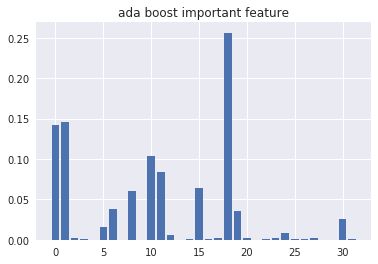

In [44]:
plt.bar(np.arange(32), ada.feature_importances_)
plt.title('ada boost important feature')
plt.show()

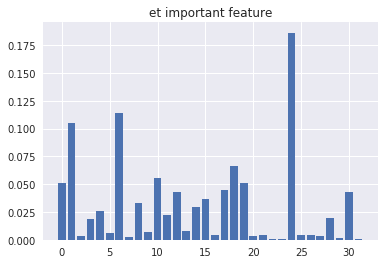

In [45]:
plt.bar(np.arange(32), et.feature_importances_)
plt.title('et important feature')
plt.show()

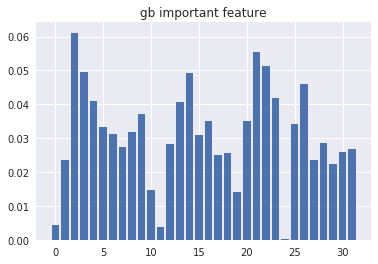

In [46]:
plt.bar(np.arange(32), gb.feature_importances_)
plt.title('gb important feature')
plt.show()

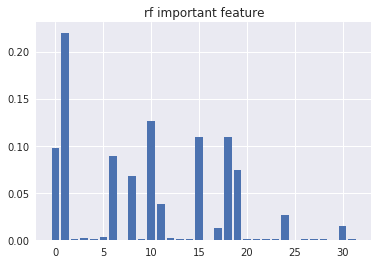

In [47]:
plt.bar(np.arange(32), rf.feature_importances_)
plt.title('rf important feature')
plt.show()

In [48]:
ada_pred=ada.predict(thought_vector)
bagging_pred=bagging.predict(thought_vector)
et_pred=et.predict(thought_vector)
gb_pred=gb.predict(thought_vector)
rf_pred=rf.predict(thought_vector)
stack_predict = np.vstack([ada_pred,bagging_pred,et_pred,gb_pred,rf_pred,df_log.iloc[:, 3]]).T
corr_df = pd.DataFrame(stack_predict)

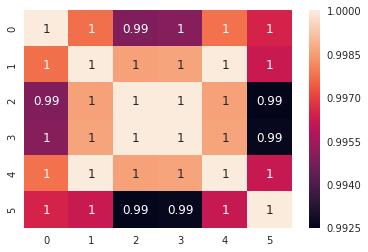

In [49]:
sns.heatmap(corr_df.corr(), annot=True)
plt.show()

# Wow, I do not expect this heatmap. Totally a heat!

In [55]:
import xgboost as xgb
params_xgd = {
    'max_depth': 7,
    'objective': 'reg:logistic',
    'learning_rate': 0.05,
    'n_estimators': 10000
    }
train_Y = df_log.iloc[:-1, 3]
clf = xgb.XGBRegressor(**params_xgd)
clf.fit(stack_predict[1:,:],train_Y, eval_set=[(stack_predict[1:,:],train_Y)], 
        eval_metric='rmse', early_stopping_rounds=20, verbose=False)

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.05, max_delta_step=0, max_depth=7,
       min_child_weight=1, missing=None, n_estimators=10000, nthread=-1,
       objective='reg:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [56]:
xgb_pred = clf.predict(stack_predict)
date_ori=pd.Series(date_ori).dt.strftime(date_format='%Y-%m-%d').tolist()

In [57]:
def reverse_close(array):
    return minmax.inverse_transform(array.reshape((-1,1))).reshape((-1))

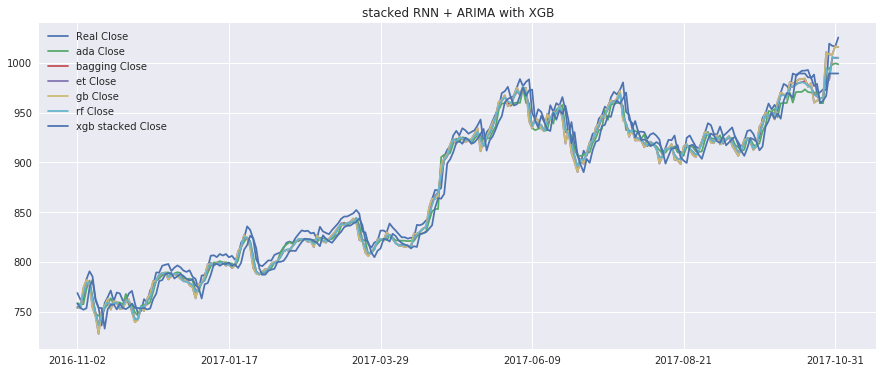

In [60]:
plt.figure(figsize = (15,6))
x_range = np.arange(len(date_ori))
plt.plot(x_range, df.Close, label = 'Real Close')
plt.plot(x_range, reverse_close(ada_pred), label = 'ada Close')
plt.plot(x_range, reverse_close(bagging_pred), label = 'bagging Close')
plt.plot(x_range, reverse_close(et_pred), label = 'et Close')
plt.plot(x_range, reverse_close(gb_pred), label = 'gb Close')
plt.plot(x_range, reverse_close(rf_pred), label = 'rf Close')
plt.plot(x_range, reverse_close(xgb_pred), label = 'xgb stacked Close')
plt.legend()
plt.xticks(x_range[::50], date_ori[::50])
plt.title('stacked RNN + ARIMA with XGB')
plt.show()